### Importing libraries

In [8]:
from ctypes import *              # import the C compatible data types
import time
from sys import platform, path    # this is needed to check the OS type and get the PATH
from os import sep                 # OS specific file path separators
import matplotlib.pyplot as plt
import numpy
import datetime
import os
import sys

### Platform agnostic SDK initialization

In [9]:
if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
path.append(constants_path)
import dwfconstants as constants

In [10]:
device_count = c_int()
dwf.FDwfEnum(c_int(), byref(device_count))
hdwf=c_int()
dwf.FDwfDeviceOpen(c_int(0), byref(hdwf))

0

In [ ]:
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value) # flags to show usb devices only
filter_flags = c_int(filter_flags.value | constants.enumfilterDemo.value) # flags to include demo devices ; comment this line to exclude
# Enumerate devices
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))
print(f"Number of devices found: {device_count.value}")
# Retrieve device name (optional)
name_buf = create_string_buffer(64) # buffer to store device name
sn_buf = create_string_buffer(32) # buffer to store device serial nmber
opn_status = c_int() # to store device opening status
status_lookup = lambda code: {
    0: "Not opened",
    1: "Opened by current process",
    2: "Opened by another process"
}.get(code, "Unknown status")

for i in range(device_count.value):
    dwf.FDwfEnumDeviceName(c_int(i), name_buf)
    dwf.FDwfEnumSN(c_int(i), sn_buf)
    dwf.FDwfEnumDeviceIsOpened(c_int(i),byref(opn_status))
    print(f"Detected device {i}\nname: {name_buf.value.decode()}\nserial: {sn_buf.value.decode()}\n{status_lookup(opn_status.value)}\n")
hdwf = c_int()
idx=int(input())
dwf.FDwfEnumDeviceIsOpened(c_int(idx),byref(opn_status))
if(opn_status.value==0):
    dwf.FDwfDeviceOpen(c_int(idx), byref(hdwf))
    if hdwf.value == 0:
        raise RuntimeError("Failed to open device.")
    print(f"device opened successfully!")
else:
    print(status_lookup(opn_status.value))

In [ ]:
dwf.FDwfAnalogInReset(hdwf)
dwf.FDwfDeviceCloseAll()
dwf.FDwfDeviceClose(hdwf)

In [ ]:
sampling_frequency = 20e05
buffer_size = 1000
amplitude_range = 5
offset = 0
sts = c_byte()
rgdSamples = (c_double*c_int(buffer_size).value)()

# the device will only be configured when FDwf###Configure is called
dwf.FDwfDeviceAutoConfigureSet(hdwf, c_int(0))

# enable channel 1
dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_bool(True))
 
# set offset voltage (in Volts)
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(0), c_double(offset))
 
# set range (maximum signal amplitude in Volts)
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(amplitude_range))
 
# set the buffer size (data point in a recording)
dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(buffer_size))
 
# set the acquisition frequency (in Hz)
dwf.FDwfAnalogInFrequencySet(hdwf,c_double(sampling_frequency))
 
# disable averaging (for more info check the documentation)
dwf.FDwfAnalogInChannelFilterSet(hdwf, c_int(-1), constants.filterDecimate)

dwf.FDwfAnalogInConfigure(hdwf, c_int(1),c_int(0))
# dwfFDwf###Configure(hdwf, c_int(1),c_int(0))

time.sleep(2)

print("Starting oscilloscope")
dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1))

while True:
    dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
    if sts.value == constants.DwfStateDone.value :
        break
    # time.sleep(0.1)
print("Acquisition done")

dwf.FDwfAnalogInStatusData(hdwf, 0, rgdSamples, c_int(buffer_size).value) # get channel 1 data

#plot window
dc = sum(rgdSamples)/len(rgdSamples)
print("DC: "+str(dc)+"V")

plt.plot(numpy.fromiter(rgdSamples, dtype = numpy.float64))
plt.show()

In [4]:
wavegen_frequency = 1e4
wavegen_dc = 1.0
wavegen_amplitude = 1.0

# Enable the waveform generator output (channel 0, node 0)
# - hdwf: device handle
# - 0: channel index
# - 0: node (main signal path, typically "Carrier")
# - 1: enable (True)
dwf.FDwfAnalogOutNodeEnableSet(hdwf, 0, 0, 1)

# Set the waveform type to sine wave
# - funcSine: predefined constant for sine waveform
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, 0, 0, constants.funcSquare)

# Set the frequency of the output sine wave to 10,000 Hz (10 kHz)
# dwf.FDwfAnalogOutNodeFrequencySet(hdwf, 0, 0, c_double(wavegen_frequency))

# Set the DC offset of the waveform to 0 V (centers it around 0)
dwf.FDwfAnalogOutNodeOffsetSet(hdwf, 0, 0, c_double(wavegen_dc))

# Set the peak amplitude of the sine wave to 1 V
# (i.e., the wave will swing from -1V to +1V)
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, 0, 0, c_double(wavegen_amplitude))

# Start the output signal
# - 0: channel index
# - 1: start (True)
dwf.FDwfAnalogOutConfigure(hdwf, 0, 1)

1

In [ ]:
"""
   DWF Python Example
   Author:  Digilent, Inc.
   Revision:  2018-07-19

   Requires:                       
       Python 2.7, 3
"""

from ctypes import *
from dwfconstants import *
import time
import sys

if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

#declare ctype variables
hdwf = c_int()
voltage1 = c_double()
voltage2 = c_double()

#print(DWF version
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

#open device
"Opening first device..."
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))

if hdwf.value == hdwfNone.value:
    szerr = create_string_buffer(512)
    dwf.FDwfGetLastErrorMsg(szerr)
    print(szerr.value)
    print("failed to open device")
    quit()

dwf.FDwfDeviceAutoConfigureSet(hdwf, c_int(0)) # 0 = the device will only be configured when FDwf###Configure is called

print("Preparing to read sample...")
dwf.FDwfAnalogInChannelEnableSet(hdwf, c_int(0), c_int(1)) 
dwf.FDwfAnalogInChannelOffsetSet(hdwf, c_int(0), c_double(0)) 
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(0), c_double(5)) 
dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(0))

time.sleep(2)

for i in range(5):
    time.sleep(1)
    dwf.FDwfAnalogInStatus(hdwf, c_int(False), None) # fetch status and samples from device
    dwf.FDwfAnalogInStatusSample(hdwf, c_int(0), byref(voltage1))
    dwf.FDwfAnalogInStatusSample(hdwf, c_int(1), byref(voltage2))
    print("Channel 1:  " + str(voltage1.value)+" V")
    print("Channel 2:  " + str(voltage2.value)+" V")

dwf.FDwfDeviceCloseAll()


DWF Version: b'3.24.4'
Opening first device
Generating sine wave...
Samples: 16384
Starting oscilloscope
Acquisition done


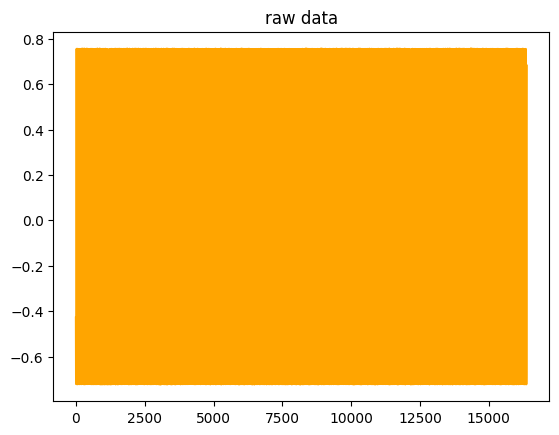

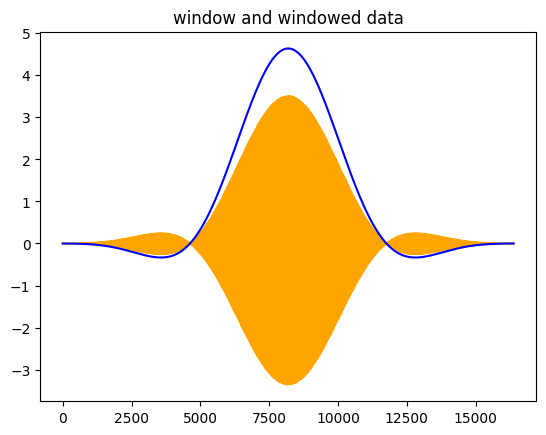

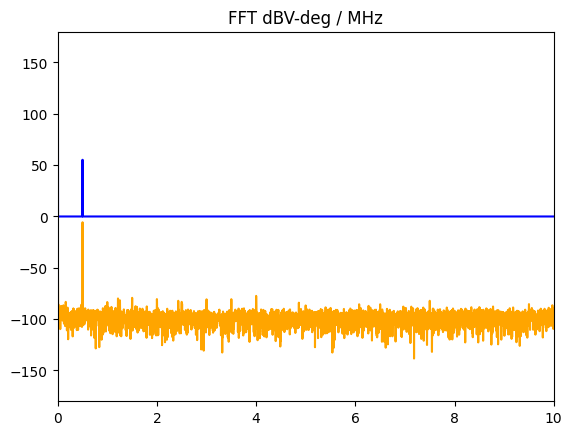

C1 peak:  500.48828125 kHz


In [11]:
"""
   DWF Python Example
   Author:  Digilent, Inc.
   Revision:  2022-08-01

   Requires:                       
       Python 2.7, 3
"""

from ctypes import *
# from dwfconstants import *
import sys
import math
import time
import matplotlib.pyplot as plt
from sys import platform, path    # this is needed to check the OS type and get the PATH
from os import sep                 # OS specific file path separators
import numpy

if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
path.append(constants_path)
from dwfconstants import * 


version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

# prevent temperature drift
dwf.FDwfParamSet(DwfParamOnClose, c_int(0)) # 0 = run, 1 = stop, 2 = shutdown

hdwf = c_int()
print("Opening first device")
if dwf.FDwfDeviceOpen(-1, byref(hdwf)) != 1 or hdwf.value == hdwfNone.value:
    szerr = create_string_buffer(512)
    dwf.FDwfGetLastErrorMsg(szerr)
    print(szerr.value)
    print("failed to open device")
    quit()

dwf.FDwfDeviceAutoConfigureSet(hdwf, c_int(0)) # 0 = the device will only be configured when FDwf###Configure is called

print("Generating sine wave...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), AnalogOutNodeCarrier, funcSine)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(500000))
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, c_int(0), AnalogOutNodeCarrier, c_double(0.705))
dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_int(1))


# capture up to 32Ki if samples
nBufMax = c_int()
dwf.FDwfAnalogInBufferSizeInfo(hdwf, 0, byref(nBufMax))
nSamples = min(32768, nBufMax.value)
nSamples = int(2**round(math.log2(nSamples)))
print("Samples: "+str(nSamples)) 

#set up acquisition
dwf.FDwfAnalogInFrequencySet(hdwf, c_double(20000000.0))
dwf.FDwfAnalogInBufferSizeSet(hdwf, nSamples)
dwf.FDwfAnalogInChannelEnableSet(hdwf, 0, 1) # enable channel 0 (C1)
dwf.FDwfAnalogInChannelRangeSet(hdwf, 0, c_double(2)) # 2V pk2pk

# wait at least 2 seconds for the offset to stabilize after the first connection
dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(0))
time.sleep(0.1)

print("Starting oscilloscope")
if dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(1)) != 1 :
    szerr = create_string_buffer(512)
    dwf.FDwfGetLastErrorMsg(szerr)
    print(szerr.value)
    quit()

hzRate = c_double()
dwf.FDwfAnalogInFrequencyGet(hdwf, byref(hzRate))

while True:
    sts = c_byte()
    # fetch status and data from device
    if dwf.FDwfAnalogInStatus(hdwf, 1, byref(sts)) != 1 :
        szerr = create_string_buffer(512)
        dwf.FDwfGetLastErrorMsg(szerr)
        print(szerr.value)
        quit()
    if sts.value == DwfStateDone.value :
        break
print("Acquisition done")

rgdSamples1 = (c_double*nSamples)()

dwf.FDwfAnalogInStatusData(hdwf, 0, rgdSamples1, nSamples) # get channel 1 data
dwf.FDwfDeviceCloseAll()

plt.title("raw data")
plt.plot(numpy.fromiter(rgdSamples1, dtype = numpy.float64), color='orange', label='C1')
plt.show()


hzTop = hzRate.value/2
rgdWindow = (c_double*nSamples)()
vBeta = c_double(1.0) # used only for Kaiser window
vNEBW = c_double() # noise equivalent bandwidth
dwf.FDwfSpectrumWindow(byref(rgdWindow), c_int(nSamples), DwfWindowFlatTop, vBeta, byref(vNEBW))

for i in range(nSamples):
    rgdSamples1[i] = rgdSamples1[i]*rgdWindow[i]

plt.title("window and windowed data")
plt.plot(numpy.fromiter(rgdSamples1, dtype = numpy.float64), color='orange', label='C1')
plt.plot(numpy.fromiter(rgdWindow, dtype = numpy.float64), color='blue', label='W')
plt.show()


# requires power of two number of samples and BINs of samples/2+1
nBins = int(nSamples/2+1)
rgdBins1 = (c_double*nBins)()
rgdPhase1 = (c_double*nBins)()
dwf.FDwfSpectrumFFT(byref(rgdSamples1), nSamples, byref(rgdBins1), byref(rgdPhase1), nBins)

sqrt2 = math.sqrt(2)
for i in range(nBins): 
    rgdBins1[i] = 20.0*math.log10(rgdBins1[i]/sqrt2) # to dBV

for i in range(nBins): 
    if rgdBins1[i]<-60 : rgdPhase1[i] = 0  # mask phase at low magnitude
    else: rgdPhase1[i] = rgdPhase1[i]*180.0/math.pi # radian to degree
    if rgdPhase1[i] < 0 : rgdPhase1[i] = 180.0+rgdPhase1[i] 

rgMHz = []
for i in range(nBins): 
    rgMHz.append(hzTop*i/(nBins-1)/1e6)

rgBins1 = numpy.fromiter(rgdBins1, dtype = numpy.float64)
rgPhase1 = numpy.fromiter(rgdPhase1, dtype = numpy.float64)

plt.title("FFT dBV-deg / MHz")
plt.xlim([0, hzTop/1e6])
plt.ylim([-180.0, 180.0])
#plt.xticks(numpy.arange(0, hzTop/1e6, hzTop/2e7))
plt.plot(rgMHz, rgBins1, color='orange', label='dBV')
plt.plot(rgMHz, rgPhase1, color='blue', label='deg')
plt.show()


iPeak1 = 0
vMax = float('-inf')
for i in range(5, nBins): # skip DC
    if rgBins1[i] < vMax: continue
    vMax = rgBins1[i]
    iPeak1 = i

print("C1 peak: ", hzTop*iPeak1/(nBins-1)/1000,"kHz")


